# 準備

## ライブラリの準備

In [1]:
import sys

if 'google.colab' in sys.modules:
    !pip install japanize-matplotlib -qqq

In [2]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## 人工データの生成

今回使用する人工データは、サインカーブに正規分布に従う乱数をノイズとして加えて生成した。
シード値は関数内で固定しているのでいつも同じ乱数を返す。

数式で表すと、 $\mathcal{N}(\sin(x), (0.5)^2)$ である。

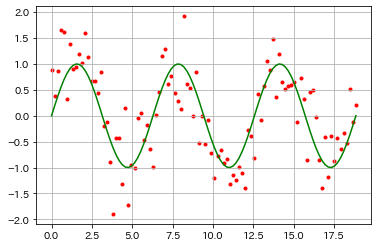

In [3]:
def make_curve(n=100, std=0.5, return_true=False):
    np.random.seed(0)
    x = np.linspace(0, 6*np.pi, n).reshape(-1, 1)
    true = np.sin(x)
    y = true + np.random.normal(scale=0.5, size=[n, 1])
    if return_true:
        return x, y, true
    return x, y

x, y, true = make_curve(return_true=True)
plt.plot(x, true, color="g")
plt.scatter(x, y, marker=".", color="r")
plt.grid(True)

↑真のモデル（緑)と人工データ（赤）の図。

$0 < x < 2.5$ らへんでは、赤点が緑線の上に分布しがちだったり、 $(x, y) = (8, 2)$ らへんに外れ値があったりする。
このようなノイズの影響を受けたデータに対してどのように反応するのかをみると面白い。

## 共通の処理を関数化

In [4]:
def show(x, y, model, pred):
    fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
    l.scatter(x, y, marker=".", color="r")
    l.plot(x, model.predict(x))
    r.scatter(x, y, marker=".", color="r")
    r.plot(x, pred, color="k")
    return l, r

In [5]:
def predict(x, model):
    def relu(X):
        return np.maximum(X, 0, out=X)

    act = x.reshape(-1, 1)
    for w, w0 in zip(model.coefs_, model.intercepts_):
        act = relu(act) @ w + w0
        
    return act

In [6]:
def count_params(model):
    param_num = 0
    for c in model.coefs_:
        m, n = c.shape
        param_num += m * n
    for i in model.intercepts_:
        n, *_ = i.shape
        param_num += n
    print(f"パラメータの個数: {param_num}")

# 理論編

小さな線形回帰モデルの出力を非線形変換したものを、また次の小さな線形回帰モデルに入力することを繰り返したものがニューラルネットワーク。数式で表現しようとすると複雑すぎるので、丸と線で表現された計算グラフがよく使われる。

todo

# 実装編

## 隠れ層が一層のニューラルネットワーク

パラメータの個数: 901


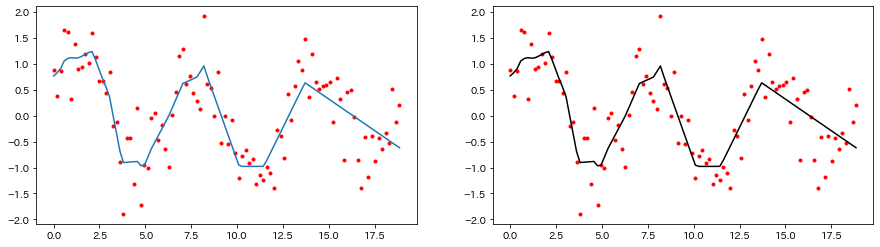

In [7]:
from sklearn.neural_network import MLPRegressor

mlp1 = MLPRegressor(hidden_layer_sizes=(300,), alpha=0.1,
                   solver="lbfgs", max_iter=2000, random_state=0)
mlp1.fit(x, y.ravel())

pred = predict(x, mlp1)
show(x, y, mlp1, pred);
count_params(mlp1)

## 隠れ層が二層のニューラルネットワーク

パラメータの個数: 881


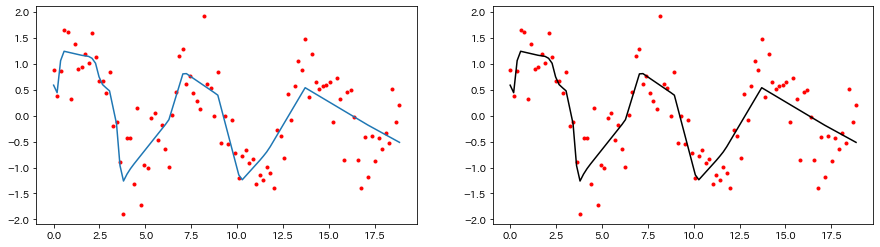

In [8]:
from sklearn.neural_network import MLPRegressor

mlp2 = MLPRegressor(hidden_layer_sizes=(50, 15), alpha=0.05,
                   solver="lbfgs", max_iter=5000, random_state=0)
mlp2.fit(x, y.ravel())

pred = predict(x, mlp2)
show(x, y, mlp2, pred);
count_params(mlp2)

## 隠れ層が三層ニューラルネットワーク

パラメータの個数: 901


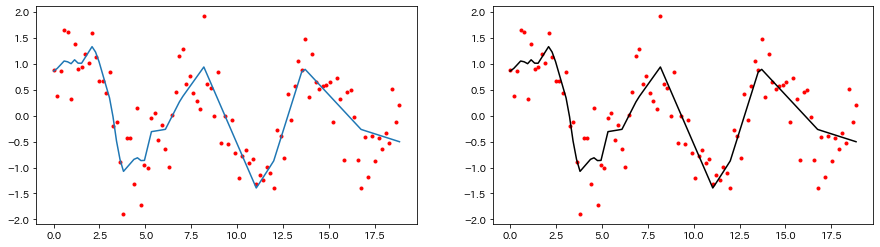

In [10]:
from sklearn.neural_network import MLPRegressor

mlp3 = MLPRegressor(hidden_layer_sizes=(20, 20, 20), alpha=1e-5,
                   solver="lbfgs", max_iter=1000, random_state=0)
mlp3.fit(x, y.ravel())

pred = predict(x, mlp3)
show(x, y, mlp3, pred);
count_params(mlp3)

# 感想編

ちょいちょい違いはあるけど大体の特徴は似ている。
実は隠れ層は一層だけでも任意のモデルを作ることができるという定理があるらしい。

ReLU 関数を活性化関数にしたときの回帰線は折れ線グラフになる。

> ？？？「ふん、ニューラルネットワークというのかい。贅沢な名だねぇ。今からお前の名前は**折れ線グラフ**だ。いいかい。**折れ線グラフ**だよ。」

名前はかっこいいが理論的には大したことをやっているわけではない。しかしこのモデルの強いところは、モデルに前提を一切置いていないところにある。そのため、ハイパーパラメータ（層やノードの数など）をいい感じに設定すれば近似できないものはないとも言える。（いい感じを見つけるのが大変なのだが…）

tanh 関数はカーブが2つあるので、パラメータの数を少なくしてもうまく表現できたかもしれない。
さらに、カーブが曲線なので真のモデルに近づけたかもしれない。

ニューラルネットワークはモデル内部で、線形回帰モデルのアンサンブルをしている。
正則化と似た手法であるドロップアウト法を初めて知ったとき、ブートストラップサンプリングではないがバギングのように、ランダムに良いモデルだけを残しているように感じた。アンサンブル学習の手法をモデル自体に取り込むと強くなるというのが今のスタンダードになるのかもしれない。